# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [2]:
%%timeit
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Big Data with Spark") \
    .getOrCreate()

# to check spark WebUI: http://localhost:4040/jobs/ or call directly 'spark' to get a link

615 µs ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
# check spark session details
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
pwd

'/home/freemo/Projects/projectSpark'

In [6]:
mini = '/home/freemo/Projects/largeData/mini_sparkify_event_data.json'
medium = '/home/freemo/Projects/largeData/medium_sparkify_event_data.json'

In [7]:
df = spark.read.json(medium)

In [8]:
# check first row
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [9]:
# check header 
df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [10]:
# enable eager evaluation for Jupyter notebooks
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [11]:
df

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Mac...",293
John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,Houston-The Woodl...,PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Mac...",98
Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,Orlando-Kissimmee...,PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Mac...",179
null,Logged In,Maverick,M,185,Santiago,null,paid,Orlando-Kissimmee...,PUT,Logout,1535953455000,178,null,307,1538352119000,"""Mozilla/5.0 (Mac...",179
Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Wind...,246
Carter USM,Logged In,Sofia,F,266,Gordon,138.29179,paid,"Rochester, MN",PUT,NextSong,1533175710000,162,Airplane Food,200,1538352125000,"""Mozilla/5.0 (Mac...",163
null,Logged Out,null,null,186,null,null,paid,null,GET,Home,null,178,null,200,1538352148000,null,
null,Logged Out,null,null,187,null,null,paid,null,GET,Home,null,178,null,200,1538352151000,null,
null,Logged Out,null,null,188,null,null,paid,null,GET,Home,null,178,null,200,1538352168000,null,
null,Logged Out,null,null,189,null,null,paid,null,PUT,Login,null,178,null,307,1538352169000,null,


In [12]:
# display info with spark
df.show(1, vertical=True)

-RECORD 0-----------------------------
 artist        | Martin Orford        
 auth          | Logged In            
 firstName     | Joseph               
 gender        | M                    
 itemInSession | 20                   
 lastName      | Morales              
 length        | 597.55057            
 level         | free                 
 location      | Corpus Christi, TX   
 method        | PUT                  
 page          | NextSong             
 registration  | 1532063507000        
 sessionId     | 292                  
 song          | Grand Designs        
 status        | 200                  
 ts            | 1538352011000        
 userAgent     | "Mozilla/5.0 (Mac... 
 userId        | 293                  
only showing top 1 row



In [13]:
# check info
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
# check columns wiht missing data
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [15]:
# check columns with Null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [16]:
# missing values in userID
df.select([count(when(isnan('userID'),True))]).show()

+--------------------------------------------+
|count(CASE WHEN isnan(userID) THEN true END)|
+--------------------------------------------+
|                                           0|
+--------------------------------------------+



In [17]:
# missing values in sessionID
df.select([count(when(isnan('sessionID'),True))]).show()

+-----------------------------------------------+
|count(CASE WHEN isnan(sessionID) THEN true END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [18]:
# checking missing and null values at the same time
df.select([count(when(isnan('userID') | col('userID').isNull() , True))]).show()

+------------------------------------------------------------------+
|count(CASE WHEN (isnan(userID) OR (userID IS NULL)) THEN true END)|
+------------------------------------------------------------------+
|                                                                 0|
+------------------------------------------------------------------+



In [19]:
# checking missing and null values at the same time
df.select([count(when(isnan('sessionID') | col('sessionID').isNull() , True))]).show()

+------------------------------------------------------------------------+
|count(CASE WHEN (isnan(sessionID) OR (sessionID IS NULL)) THEN true END)|
+------------------------------------------------------------------------+
|                                                                       0|
+------------------------------------------------------------------------+



In [20]:
# convert to pandas DataFrame for a better EDA
dfp = df.toPandas()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
dfp.shape

(543705, 18)

In [22]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         432877 non-null  object 
 1   auth           543705 non-null  object 
 2   firstName      528005 non-null  object 
 3   gender         528005 non-null  object 
 4   itemInSession  543705 non-null  int64  
 5   lastName       528005 non-null  object 
 6   length         432877 non-null  float64
 7   level          543705 non-null  object 
 8   location       528005 non-null  object 
 9   method         543705 non-null  object 
 10  page           543705 non-null  object 
 11  registration   528005 non-null  float64
 12  sessionId      543705 non-null  int64  
 13  song           432877 non-null  object 
 14  status         543705 non-null  int64  
 15  ts             543705 non-null  int64  
 16  userAgent      528005 non-null  object 
 17  userId         543705 non-nul

In [23]:
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


<AxesSubplot:>

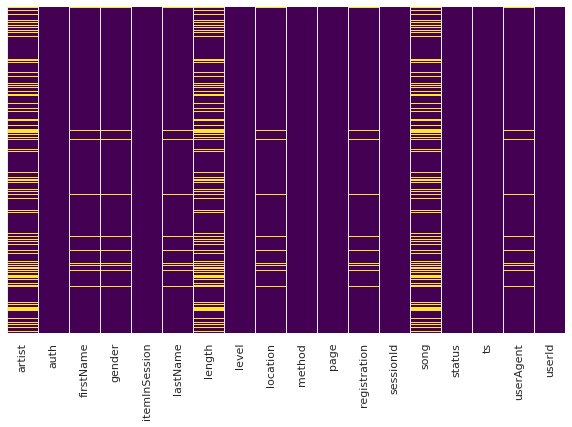

In [26]:
# check for null values with graph
plt.figure(figsize=(10,6))
sns.heatmap(dfp.isnull(), cbar=False, yticklabels=False, cmap='viridis')

<AxesSubplot:>

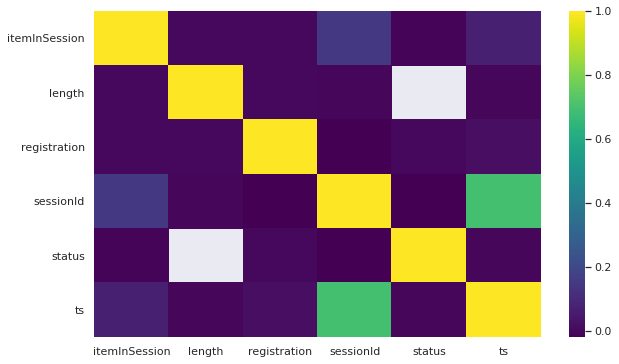

In [31]:
# check correlation
plt.figure(figsize=(10,6))
sns.heatmap(dfp.corr(),cmap='viridis',annot=False)

In [32]:
# check artist
dfp['auth'].value_counts(normalize=True)

Logged In     0.970942
Logged Out    0.028703
Cancelled     0.000182
Guest         0.000173
Name: auth, dtype: float64

In [33]:
# check level
dfp['level'].value_counts(normalize=True)

paid    0.78829
free    0.21171
Name: level, dtype: float64

In [34]:
# check method
dfp['method'].value_counts(normalize=True)

PUT    0.910683
GET    0.089317
Name: method, dtype: float64

In [35]:
# check page
dfp['page'].value_counts(normalize=True)

NextSong                     0.796162
Home                         0.050417
Thumbs Up                    0.043822
Add to Playlist              0.022713
Add Friend                   0.014874
Roll Advert                  0.014296
Login                        0.011056
Logout                       0.011017
Thumbs Down                  0.009032
Downgrade                    0.007009
Help                         0.005794
Settings                     0.005451
About                        0.003412
Upgrade                      0.001780
Save Settings                0.001076
Error                        0.000955
Submit Upgrade               0.000528
Submit Downgrade             0.000215
Cancel                       0.000182
Cancellation Confirmation    0.000182
Register                     0.000020
Submit Registration          0.000007
Name: page, dtype: float64

In [43]:
# check page
dfp['page'].value_counts()

NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Login                          6011
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Help                           3150
Settings                       2964
About                          1855
Upgrade                         968
Save Settings                   585
Error                           519
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Register                         11
Submit Registration               4
Name: page, dtype: int64

In [37]:
# check percent of missing values
dfp.isnull().sum().sort_values()/543705

userId           0.000000
auth             0.000000
ts               0.000000
status           0.000000
itemInSession    0.000000
sessionId        0.000000
level            0.000000
page             0.000000
method           0.000000
registration     0.028876
location         0.028876
lastName         0.028876
gender           0.028876
firstName        0.028876
userAgent        0.028876
length           0.203838
song             0.203838
artist           0.203838
dtype: float64

In [38]:
# check na values out of total
dfp.isna().sum().sort_values()/543705

userId           0.000000
auth             0.000000
ts               0.000000
status           0.000000
itemInSession    0.000000
sessionId        0.000000
level            0.000000
page             0.000000
method           0.000000
registration     0.028876
location         0.028876
lastName         0.028876
gender           0.028876
firstName        0.028876
userAgent        0.028876
length           0.203838
song             0.203838
artist           0.203838
dtype: float64

In [39]:
dfp['registration'].isna().sum()

15700

In [40]:
dfp['gender'].value_counts(normalize=True)

M    0.573123
F    0.426877
Name: gender, dtype: float64

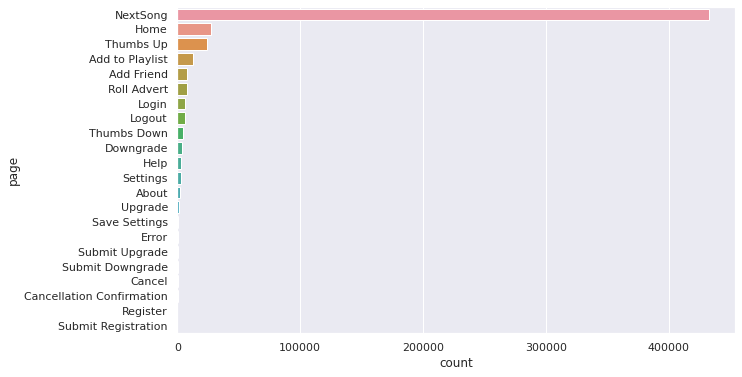

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(y="page", data=dfp, order = dfp['page'].value_counts().index)
plt.show()

<AxesSubplot:xlabel='count', ylabel='page'>

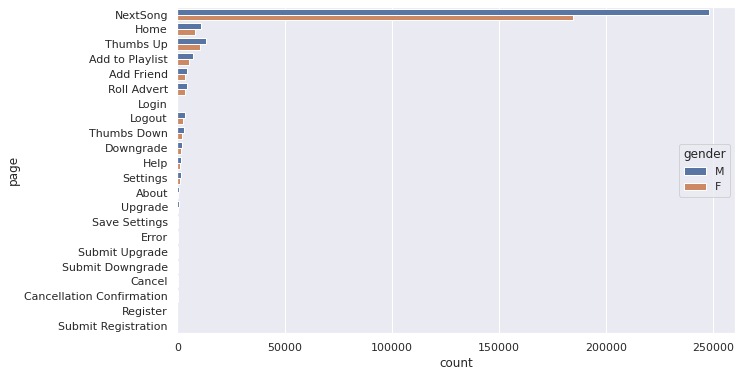

In [42]:
plt.figure(figsize=(10,6))
sns.countplot(y="page", hue="gender", data=dfp, order = dfp['page'].value_counts().index)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.